# Binary Classification with a Bank Dataset
link: https://www.kaggle.com/competitions/playground-series-s5e8/data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import clone
from collections import Counter
from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import csv
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedBaggingClassifier
import xgboost as xgb


In [3]:
df = pd.read_csv("/Users/eyash.p24/Desktop/Competitions and work/Competition/Kaggle Comp/playground-series-s5e8/train.csv", index_col="id")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.0+ MB


In [6]:
df.shape

(750000, 17)

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [8]:
df['poutcome'].unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

In [9]:
df_unknown_col = [col for col in df.columns if "unknown" in df[col].unique()]
df_unknown_col

['job', 'education', 'contact', 'poutcome']

In [10]:
[df[col].value_counts() for col in df_unknown_col]

[job
 management       175541
 blue-collar      170498
 technician       138107
 admin.            81492
 services          64209
 retired           35185
 self-employed     19020
 entrepreneur      17718
 unemployed        17634
 housemaid         15912
 student           11767
 unknown            2917
 Name: count, dtype: int64,
 education
 secondary    401683
 tertiary     227508
 primary       99510
 unknown       21299
 Name: count, dtype: int64,
 contact
 cellular     486655
 unknown      231627
 telephone     31718
 Name: count, dtype: int64,
 poutcome
 unknown    672450
 failure     45115
 success     17691
 other       14744
 Name: count, dtype: int64]

The value "Unknonw" seems significant in features such as Education, contact, poutcome.

In [11]:
df["y"].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

In [12]:
df["y"].value_counts() / df.shape[0] *100

y
0    87.934933
1    12.065067
Name: count, dtype: float64

There exist a imbalance of data. Majority of the data consist of y label 0 comprising an astonishing 87%. 

In [13]:
[f"{col}: {len(df[col].unique())}" for col in df.columns]

['age: 78',
 'job: 12',
 'marital: 3',
 'education: 4',
 'default: 2',
 'balance: 8217',
 'housing: 2',
 'loan: 2',
 'contact: 3',
 'day: 31',
 'month: 12',
 'duration: 1760',
 'campaign: 52',
 'pdays: 596',
 'previous: 50',
 'poutcome: 4',
 'y: 2']

In [14]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [15]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O' and feature != "y"]
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O" and feature != "y"]
numerical_features, categorical_features

(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'poutcome'])

In [16]:
df.shape

(750000, 17)

In [17]:
X = df.drop(["y"], axis=1)
y = df["y"]
X.shape, y.shape

((750000, 16), (750000,))

In [18]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

## Numerical

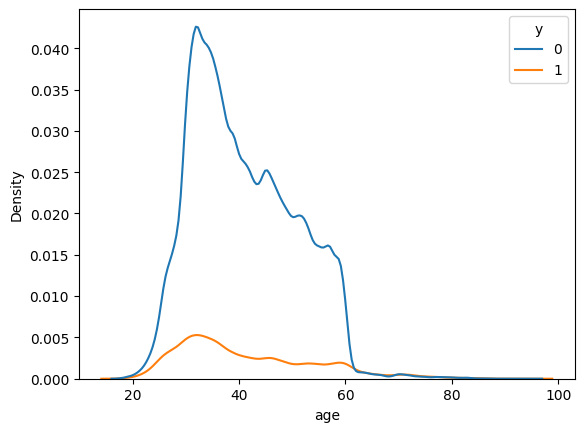

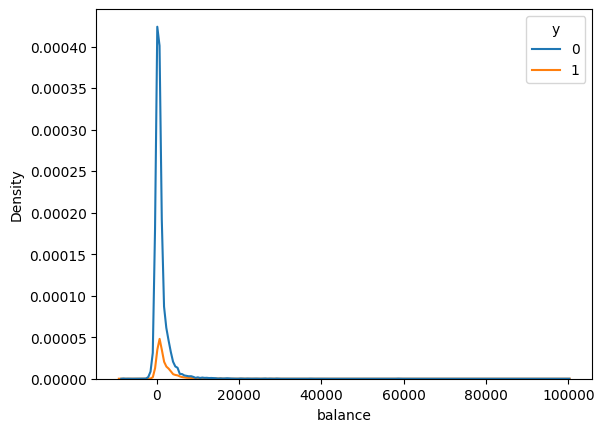

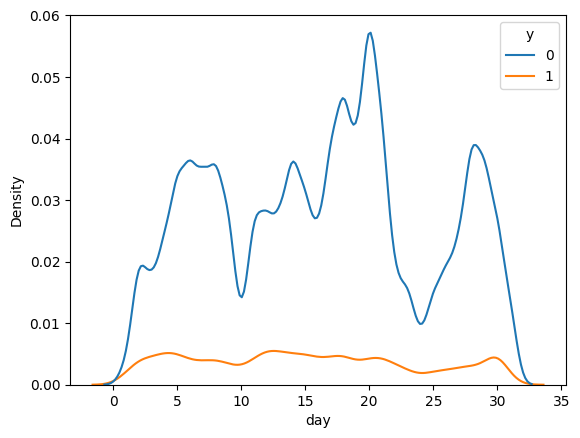

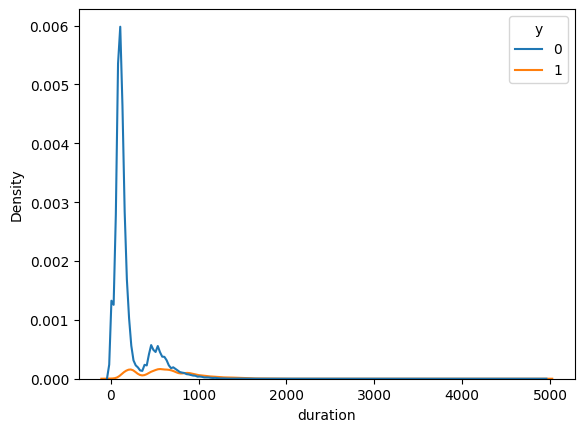

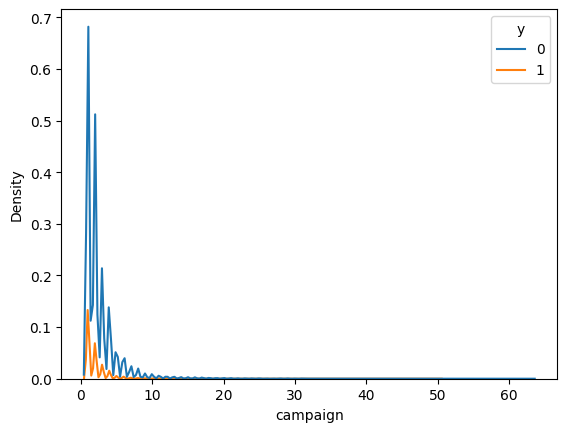

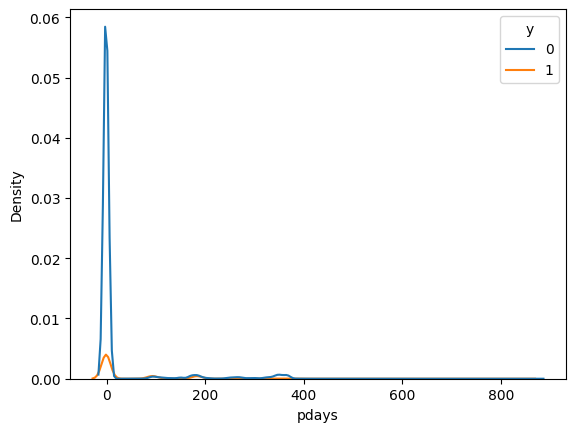

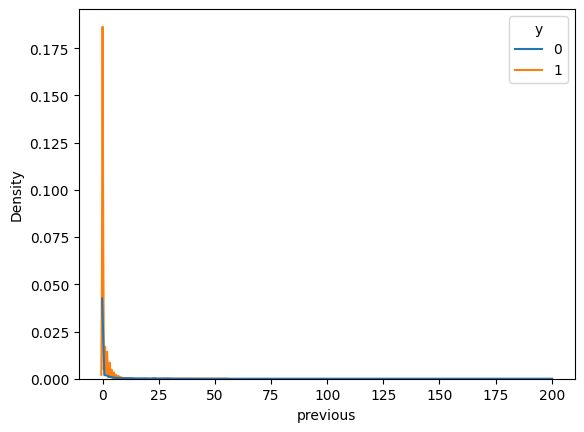

In [19]:
for feature in numerical_features:
    sns.kdeplot(data=df, x=feature, hue='y')
    plt.show()

Normalization is required for most of them as they are left-skewed

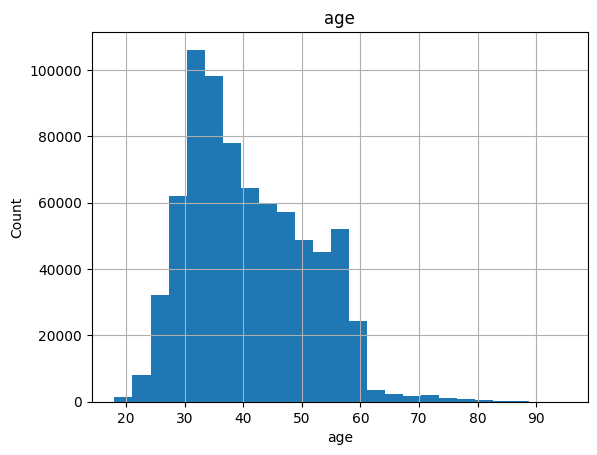

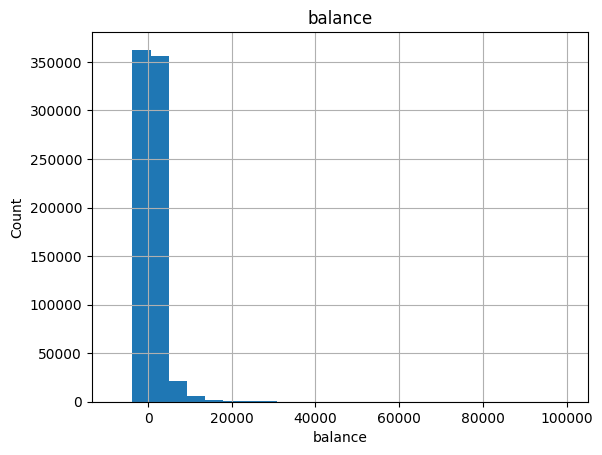

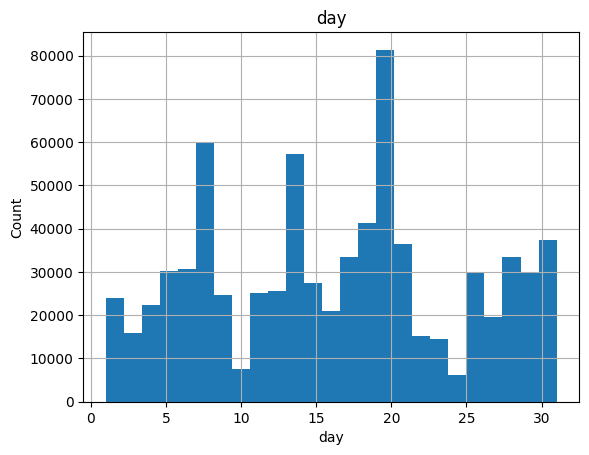

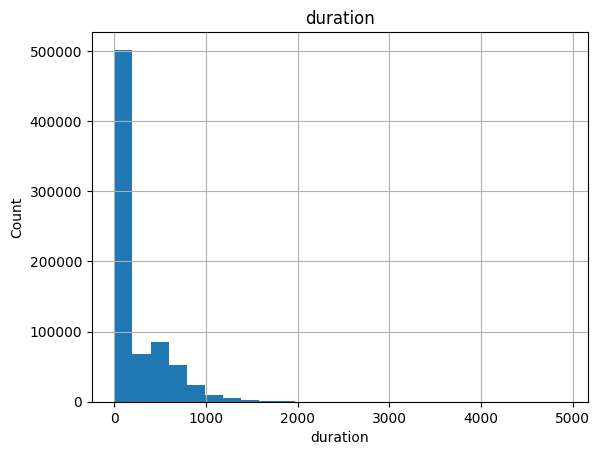

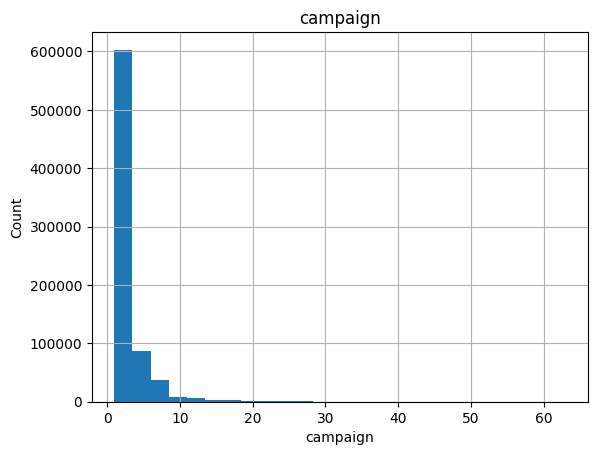

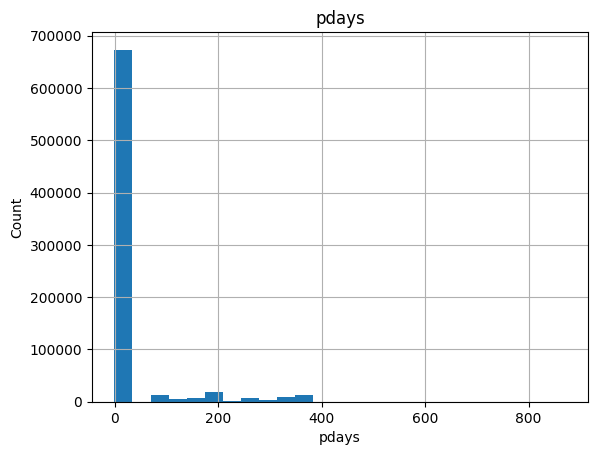

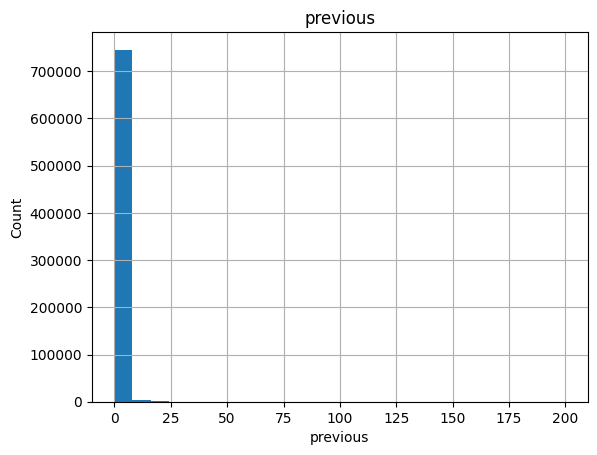

In [20]:
for feature in numerical_features:
  data = df.copy()
  data[feature].hist(bins=25)
  plt.xlabel(feature)
  plt.ylabel("Count")
  plt.title(feature)
  plt.show()

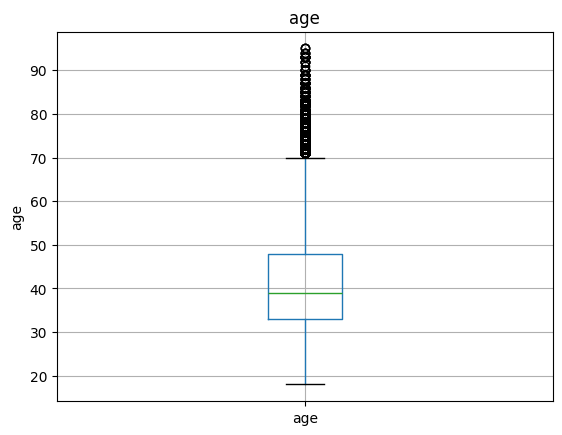

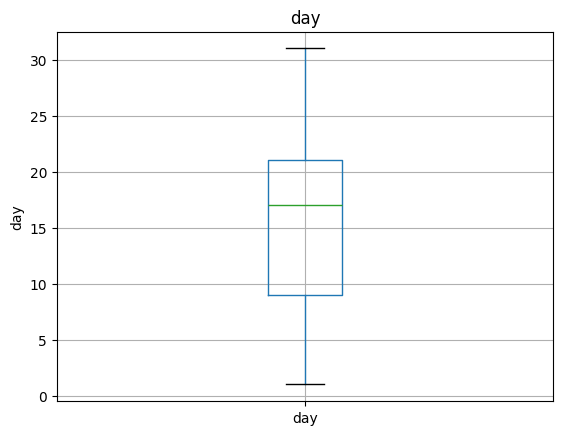

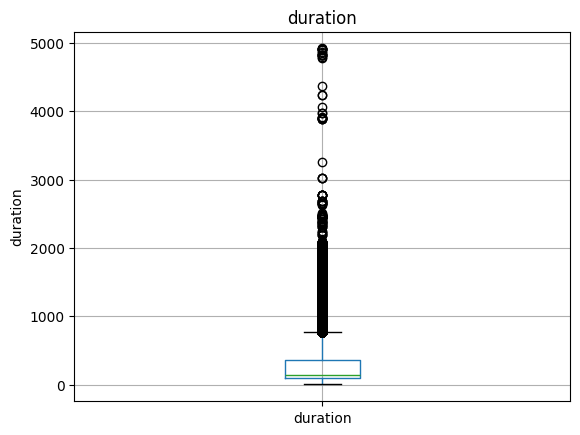

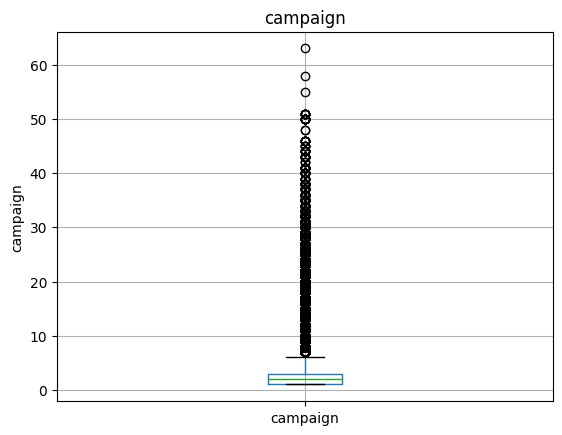

In [21]:
for feature in numerical_features:
  data = df.copy()

  if 0 in data[feature].unique(): 
    pass
  else:
    data[feature] = data[feature]
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

As evident there exist several outliers in the nuemrical columns, we have to remove them

In [22]:
df[numerical_features].describe()

,age,balance,day,duration,campaign,pdays,previous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000


In [23]:
# Scaling Standard scaler 
scaler = StandardScaler()
scaler.fit(df[numerical_features])


StandardScaler()

In [ ]:
def save_preprocessing_tools(tool, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(tool, file)

In [ ]:
save_preprocessing_tools(
    scaler, 
    "preprocessing/scaler.pkl"
)

## Categorical

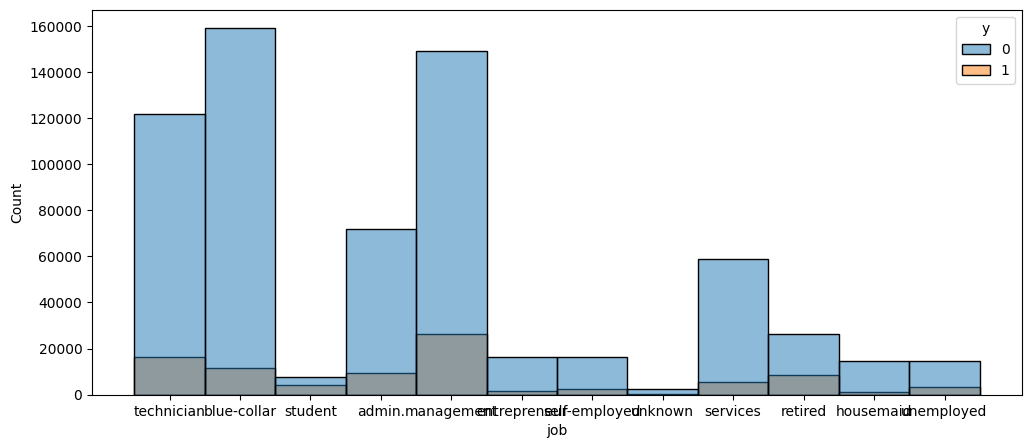

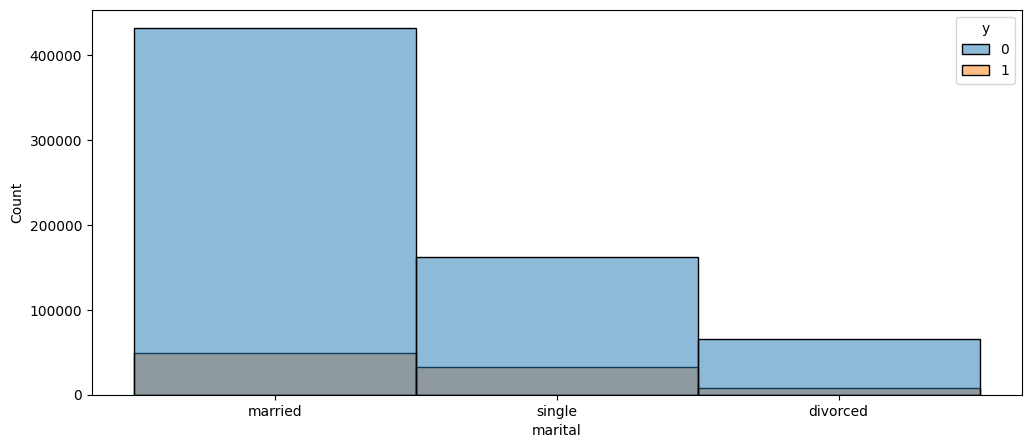

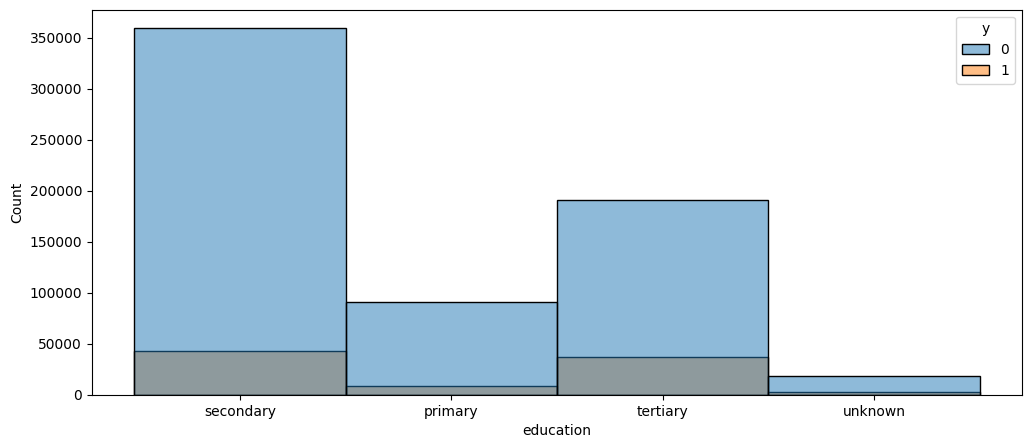

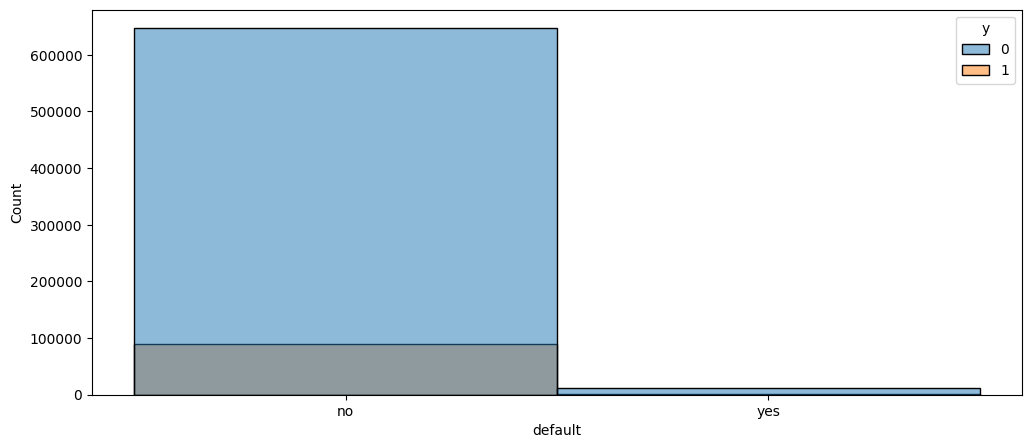

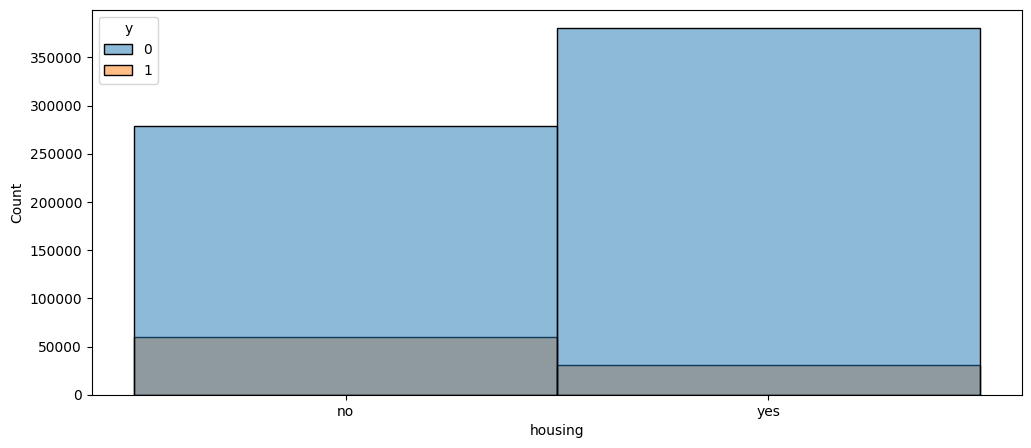

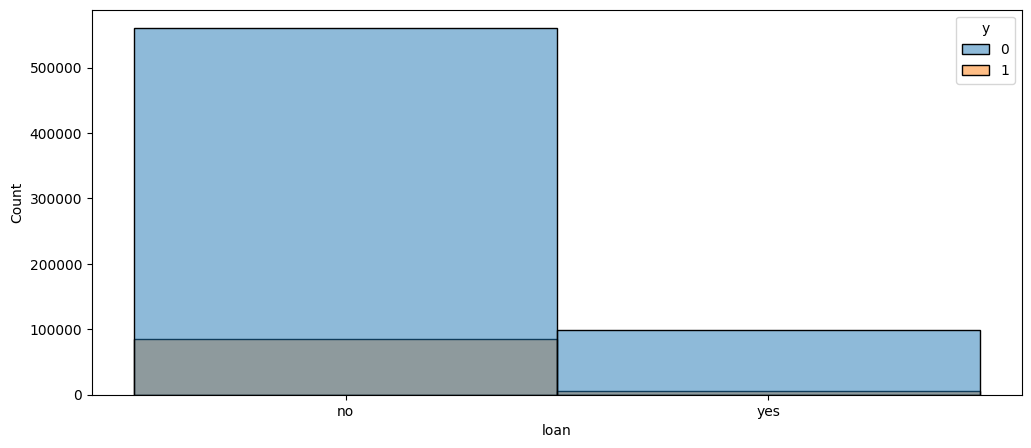

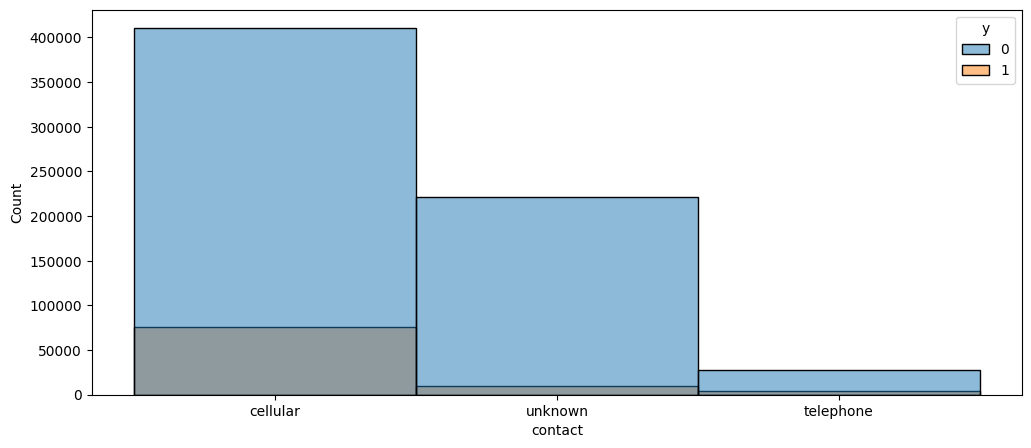

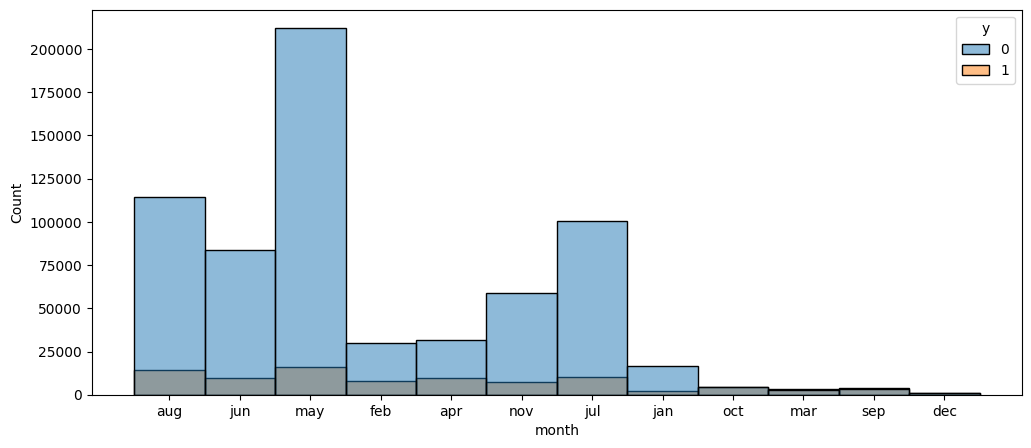

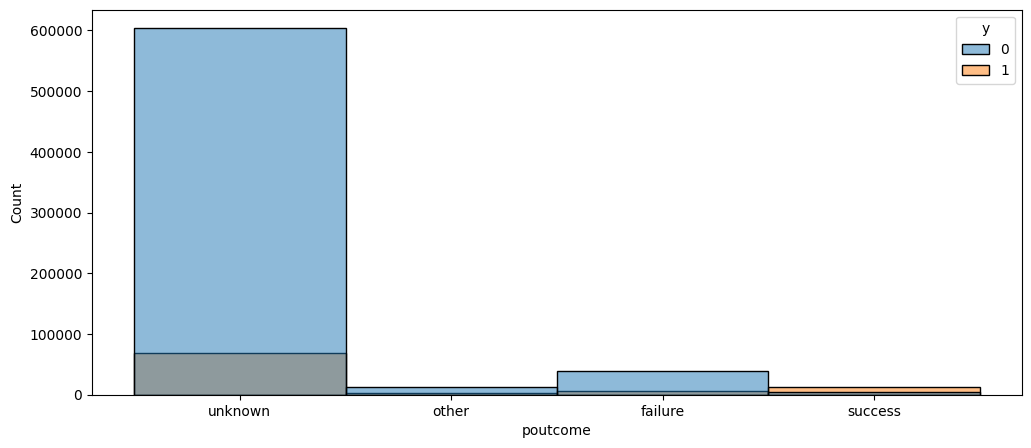

In [24]:
for feature in categorical_features:
    plt.figure(figsize=(12,5))
    sns.histplot(data=df, x=feature, hue='y')
    plt.show()

In [25]:
label_encoder = LabelEncoder()

for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])


In [ ]:
save_preprocessing_tools(
    label_encoder, 
    "preprocessing/label_encoder.pkl"
)

## Misbalanced Dataset

In [26]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,9,1,1,0,7,0,0,0,25,1,117,3,-1,0,3,0
1,38,1,1,1,0,514,0,0,2,18,6,185,1,-1,0,3,0
2,36,1,1,1,0,602,1,0,2,14,8,111,2,-1,0,3,0
3,27,8,2,1,0,34,1,0,2,28,8,10,2,-1,0,3,0
4,26,9,1,1,0,889,1,0,0,3,3,902,1,-1,0,3,1


In [27]:
X = df.drop(["y"], axis=1)
y = df['y']

In [28]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)
X_train.shape, X_test.shape

((675000, 16), (75000, 16))

In [29]:
Counter(y_test), Counter(y_train)

(Counter({0: 65951, 1: 9049}), Counter({0: 593561, 1: 81439}))

This is notably imbalanced, employing imbalanced data handling techniques

In [30]:
# Approach 1: Random Sampling
# Oversampling using RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
print("Oversampled class distribution:", Counter(y_over))

# Undersampling using RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
print("Undersampled class distribution:", Counter(y_under))

Oversampled class distribution: Counter({0: 659512, 1: 659512})
Undersampled class distribution: Counter({0: 90488, 1: 90488})


In [31]:
# Approach 2: SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [32]:
Counter(y_train_resampled)

Counter({0: 593561, 1: 593561})

## Model

In [55]:
def save_result_data(result_data, csv_file_path="model_result.csv"):
    if os.path.exists(csv_file_path):
        with open(csv_file_path, 'a') as csvfile:
            csvwriter = csv.writer(csvfile)   
            csvwriter.writerow(result_data)

    else:
        with open(csv_file_path, 'w') as csvfile:
            csvwriter = csv.writer(csvfile)   
            csvwriter.writerow(['Name', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC_AUC Score'])
            csvwriter.writerow(result_data)

    csvfile.close()

In [59]:
def model_save(model,file_name, dir='model'):
    path = os.path.join(dir, file_name)

    if os.path.exists(dir):
        pass
    else:
        os.mkdir(dir)
        
    with open(path, 'wb') as file:
        pickle.dump(model, file)

In [60]:
def evaluate_model(model, model_name):
    model_base = clone(model)
    model_oversample = clone(model)
    model_undersample = clone(model)
    model_smote = clone(model)

    model_base.fit(X_train, y_train)
    model_oversample.fit(X_over, y_over)
    model_undersample.fit(X_under, y_under)
    model_smote.fit(X_train_resampled, y_train_resampled)

    y_pred_base = model_base.predict(X_test)
    y_pred_oversample = model_oversample.predict(X_test)
    y_pred_undersample = model_undersample.predict(X_test)
    y_pred_smote = model_smote.predict(X_test)

    for type_name, y_pred in zip(["Base", "OverSampled", "UnderSampled", "SMOTE"],[y_pred_base, y_pred_oversample, y_pred_undersample, y_pred_smote]):
        print(f"Type: {type_name}")
        result = [
            model_name + "_" + type_name,
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            roc_auc_score(y_test, y_pred)
        ]
        print(result)
        save_result_data(result)    

    for model, type_name in zip([model_base, model_oversample, model_undersample, model_smote],["Base", "OverSampled", "UnderSampled", "SMOTE"]):
        file_name = model_name + "_" + type_name + ".pkl"
        model_save(model, file_name)


In [ ]:
# Models
model_logistic_regression = LogisticRegression()
model_clf = RandomForestClassifier(n_estimators=100, random_state=42)
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_ada = AdaBoostClassifier(n_estimators=100, random_state=42)
model_dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
model_dt_en = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_knn = KNeighborsClassifier(n_neighbors=5)
model_svc = SVC() 
model_gnb = GaussianNB()
model_bnb = BernoulliNB()
model_mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)

model_list = [model_logistic_regression, model_clf, model_gb, model_ada, model_dt_gini, model_dt_en, model_knn, model_svc, model_gnb, model_bnb, model_mlp]
model_name = ["logistic_regression", "clf", "gb", "ada", "dt_gini", "dt_en", "knn", "svc", "gnb", "bnb", "mlp"]

for model, name in zip(model_list, model_name):
    evaluate_model(model, name)

Type: Base
['logistic_regression_Base', 0.89808, 0.631776402175952, 0.3721958227428445, 0.46842837273991655, np.float64(0.6712156502988078)]
Type: OverSampled
['logistic_regression_OverSampled', 0.83628, 0.4106648965593539, 0.820422146093491, 0.5473513473660928, np.float64(0.8294389846781081)]
Type: UnderSampled
['logistic_regression_UnderSampled', 0.8400533333333333, 0.4171119986499409, 0.8194275610564703, 0.5528218892119585, np.float64(0.8311554569243474)]
Type: SMOTE
['logistic_regression_SMOTE', 0.8496133333333333, 0.43195410716465277, 0.7821858768924743, 0.55655592687242, np.float64(0.8205253958767538)]
Type: Base
['clf_Base', 0.93292, 0.7535335689045937, 0.6598519173389324, 0.7035880516113828, np.float64(0.8151195114586582)]
Type: OverSampled
['clf_OverSampled', 1.0, 1.0, 1.0, 1.0, np.float64(1.0)]
Type: UnderSampled
['clf_UnderSampled', 0.9017466666666667, 0.5511633572907784, 1.0, 0.7106451486237091, np.float64(0.9441327652347955)]
Type: SMOTE
['clf_SMOTE', 0.9198666666666667, 0

In [ ]:

base_classifier = RandomForestClassifier(random_state=42)
balanced_bagging_classifier = BalancedBaggingClassifier(base_classifier,
                                                        sampling_strategy='auto',  # You can adjust this parameter
                                                        replacement=False,  # Whether to sample with or without replacement
                                                        random_state=42)
evaluate_model(balanced_bagging_classifier, "bbc")

In [ ]:

model_xgb = xgb.XGBClassifier()

evaluate_model(model_xgb, 'xgb')